In [ ]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

In [ ]:
df.shape

(6335, 4)

In [ ]:
df.columns

Index(['Unnamed: 0', 'title', 'texto', 'sentimiento'], dtype='object')

In [ ]:
df = df.set_index('Unnamed: 0')

In [ ]:
df.head()

,title,texto,sentimiento
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
df.sentimiento.unique()

array(['FAKE', 'REAL'], dtype=object)

In [ ]:
# Contar cuantas noticias reales y fakes hay en el dataset
df['sentimiento'].value_counts()

# Està balanceado? Còmo lo arreglarìas sino?


,count
sentimiento,
REAL,3171
FAKE,3164


Se podria decir que el dataset esta balanceado porque hay casi la misma cantidad de noticias reales que falsas (diferencia de +7 en las reales sobre un total de 6335).

Si no estuviera balanceado, y como no quiero/puedo modificar los datos pero si que el modelo preste una atencion adecuada a la clase minoritaria, lo que haria seria asignarle un peso inversamente proporcional.

In [ ]:
# Dimensiona el dataset
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?

In [ ]:
df.shape

(6335, 3)

Este dataset utiliza variables de texto y para ML precisaria una representacion numerica de los datos. Aqui hay 3 columnas pero luego cada palabra relevante se transforma en una caracteristica numerica, lo que genera un aumento en la cantidad de variables (por ejemplo de 3 a cientos o miles)

In [ ]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?

In [ ]:
#1000 muestras aleatorias
df_reducido = df.sample(n=1000, random_state=42)
print(df_reducido.shape)

(1000, 3)


In [ ]:
#revisar el nuevo balance
df_reducido['sentimiento'].value_counts()

,count
sentimiento,
REAL,513
FAKE,487


Si bien ahora la diferencia de reales un poco mayor (26) la muestra sigue estando balanceada

In [ ]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)
df_reducido['sentimiento'] = df_reducido['sentimiento'].map({'FAKE': 0, 'REAL': 1})
print(df_reducido['sentimiento'].value_counts())

sentimiento
1    513
0    487
Name: count, dtype: int64


In [ ]:
def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)

In [ ]:
# Aplicar preprocesamiento
df_reducido['texto'] = df_reducido['texto'].apply(preprocesar_texto)




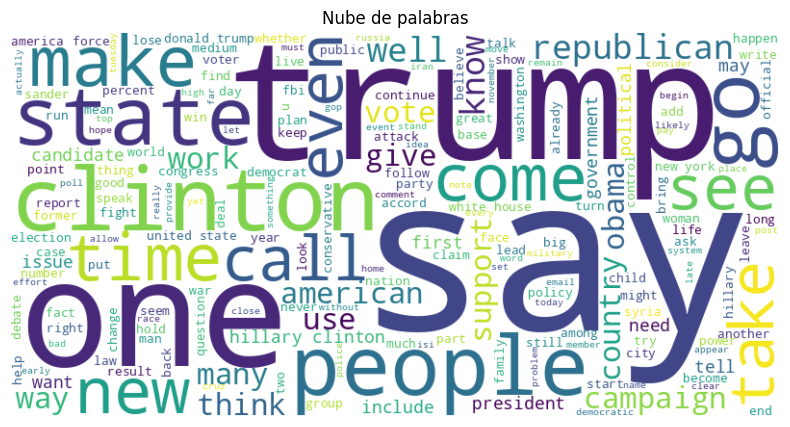

In [ ]:
# Visualizar nube de palabras completando la secuencia de creaciòn
text_combined = " ".join(df_reducido['texto'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

Unigramas más comunes:
      N-gram  Frecuencia
0        say        5327
1      trump        3712
2    clinton        3220
3      would        2302
4      state        2222
5        one        1975
6     people        1880
7       make        1662
8       year        1634
9  president        1567


<ipython-input-19-6ecea457e68b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


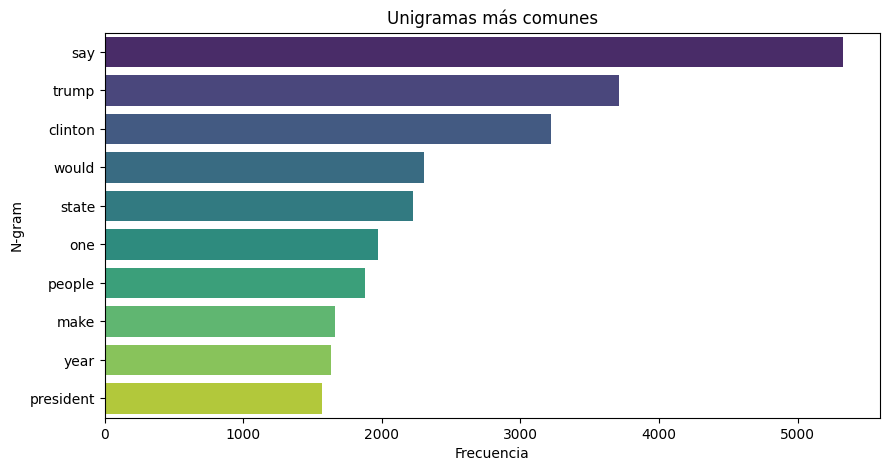


Bigramas más comunes:
            N-gram  Frecuencia
0  hillary clinton         714
1     donald trump         605
2    united states         561
3      white house         407
4         new york         402
5  secretary state         229
6  president obama         215
7    islamic state         199
8        trump say         194
9         year old         187


<ipython-input-19-6ecea457e68b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


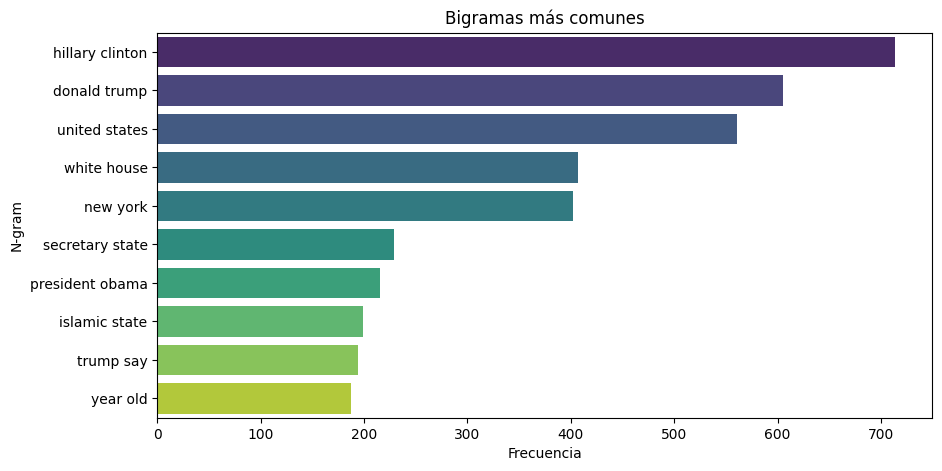


Trigramas más comunes:
                            N-gram  Frecuencia
0                   new york times          95
1           president barack obama          70
2          president united states          53
3                    new york city          52
4           former secretary state          50
5                     sen ted cruz          46
6             director james comey          43
7               fbi director james          39
8              wall street journal          39
9  republican presidential nominee          38


<ipython-input-19-6ecea457e68b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


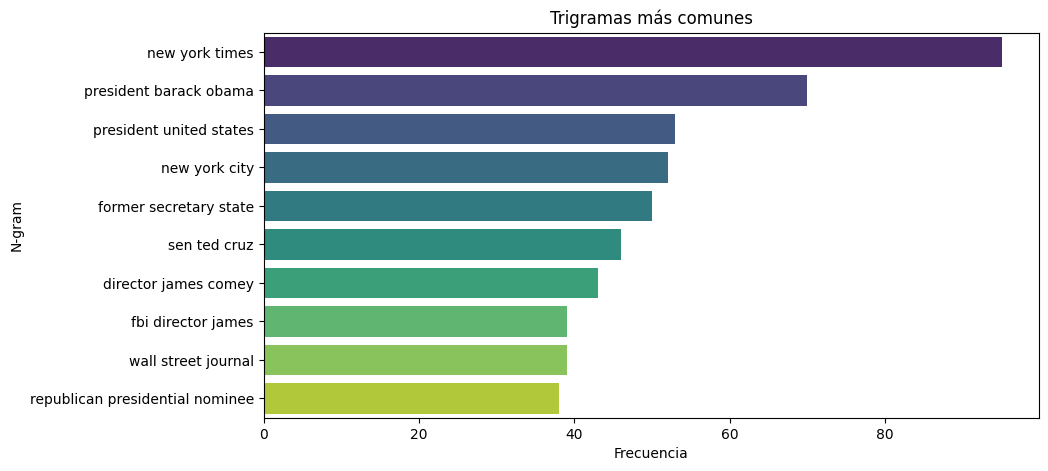


Cuatrigramas más comunes:
                               N-gram  Frecuencia
0            fbi director james comey          36
1                ohio gov john kasich          28
2  associated press contribute report          27
3     majority leader mitch mcconnell          27
4          secretary state john kerry          27
5            vice president joe biden          25
6        senate majority leader mitch          24
7             house speaker paul ryan          22
8          house speaker john boehner          20
9            use private email server          20


<ipython-input-19-6ecea457e68b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


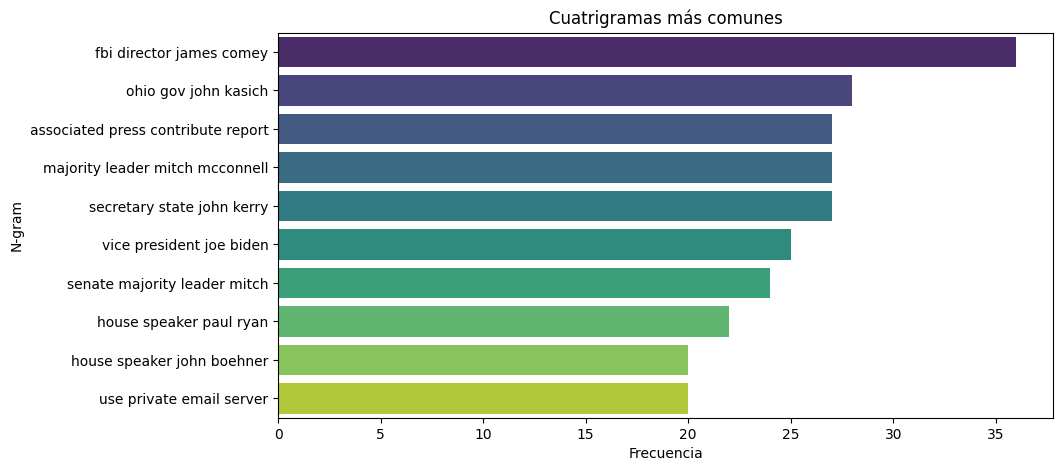

In [ ]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(df_reducido['texto'], 1)

print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

bigrams = get_top_ngrams(df_reducido['texto'], 2)
print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

trigrams = get_top_ngrams(df_reducido['texto'], 3)
print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

quatrigrams = get_top_ngrams(df_reducido['texto'], 4)
print("\nCuatrigramas más comunes:")
print(quatrigrams)
plot_ngrams(quatrigrams, "Cuatrigramas más comunes")

**El mejor n-gram para trabjar en ese caso son los bigramas,** ya que aportan mas contexto que los unigramas y son mas frecuentes que los trigramas y cuatrigramas.

Por ejemplo, la palabra "say" en el unigrama no aporta mucho porque puede estar en cualquier tipo de noticia y no da contexto ninguno. La palabra "Clinton" (3220) puede referirse a Bill o Hillary. En el bigrama aparece con claridad que se trata de "Hillary Clinton" (714) lo que permite identificar que la noticia se trata de una figura politica concreta.

Los trigramas brindan mas contexto, por ejemplo puedo ver la diferencia de frecuencia entre "New York city" y "New York times". La tercer palabra puede cambiar el sentido porque uno me ubica una noticia en un contexto geografico (City) y la otra (New York Times) es mas probable que este vinculada a noticias "reales", pero la gran desventaja que tiene es que la frecuencia baja de 402 en el bigrama a 95 o 52 en el trigrama lo que puede afectar la capidad del modelo para aprender modelos consistentes.

Los cuatrigramas dan muchisimo contexto pero baja frecuencia. Para este caso no aporta mucho mas que diga FBI Director James Comey u Ohio Gov John Kasich a expensas de tener una frecuenca tan baja (36 y 28)

**O sea los bigramas tienen un buen equilibrio entre frecuencia y valor semantico.**

In [ ]:
# Separar datos en entrenamiento y prueba
X = df_reducido['texto']
y = df_reducido['sentimiento']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 800
Tamaño del conjunto de prueba: 200


In [ ]:
# Pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [ ]:
# Entrenar modelo
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

In [ ]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.735
              precision    recall  f1-score   support

           0       0.96      0.47      0.63        97
           1       0.66      0.98      0.79       103

    accuracy                           0.73       200
   macro avg       0.81      0.73      0.71       200
weighted avg       0.81      0.73      0.72       200



In [ ]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [ ]:
y_pred2=pac.predict(tfidf_test)

In [ ]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.9
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        97
           1       0.91      0.89      0.90       103

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



# **Que es mejor en este caso, predecir probabilidad o absolutismos?**

El modelo Multinomial Naive Bayes(probabilidad) tiene un accuracy decente (73.5%), pero tiene un sesgo hacia predecir noticias reales (recall 0.98 para la clase 1 (real)). Falla en detectar Fake News (recall 0.47 para la clase 0 (fake)), lo que es un problema si el objetivo es minimizar la propagacion de noticias falsas. Con este modelo mas de la mitad de las fake news no estan siendo identificadas.

El modelo Passive-Aggressive (absolutismos) no solo muestra una accuracy del 90%, sino que el recall y la precision son equilibrados para ambas clases lo que muestra que detecta noticias reales y fake news con igual eficiencia.

**En este caso el mejor parece ser el Modelo passive-aggressive,** ya que logra una prediccion mas precisa y equilibrada.





